<a href="https://colab.research.google.com/github/JuanPablo-Ramos/ProyectoKaggle/blob/main/03%20-%20Modelo%20LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UDEA/AI4ENG 2025-1: Pruebas Saber Pro Colombia

Este notebook describe el análisis de datos, preprocesamiento y modelado para predecir el rendimiento académico de estudiantes en la prueba Saber Pro.

## Importar librerías esenciales
En esta sección cargamos las librerías necesarias para la manipulación de datos, visualización y modelado.

In [ ]:
# Imports básicos y carga de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV

import lightgbm as lgb

# Cargar archivos
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

print(f"Train: {train.shape} | Test: {test.shape}")


Train: (692500, 21) | Test: (296786, 20)


## Cargar datos de entrenamiento y prueba
Leemos los archivos `train.csv` y `test.csv` para preparar los datasets de entrenamiento y evaluación.

In [ ]:
import pandas as pd
import numpy as np

z = pd.read_csv("train.csv")
print ("Se cargaron los datos correctamente", z.shape)

Se cargaron los datos correctamente (692500, 21)


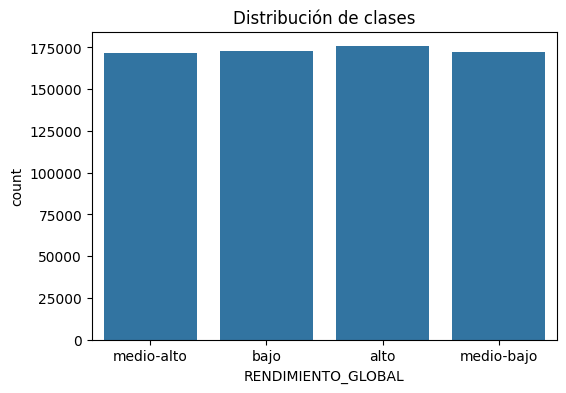

Top 20 columnas con más missing:
 FAMI_TIENEAUTOMOVIL               43623
FAMI_TIENELAVADORA                39773
FAMI_TIENECOMPUTADOR              38103
FAMI_ESTRATOVIVIENDA              32137
ESTU_HORASSEMANATRABAJA           30857
FAMI_TIENEINTERNET.1              26629
FAMI_TIENEINTERNET                26629
FAMI_EDUCACIONMADRE               23664
FAMI_EDUCACIONPADRE               23178
ESTU_PAGOMATRICULAPROPIO           6498
ESTU_VALORMATRICULAUNIVERSIDAD     6287
PERIODO                               0
ID                                    0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRIVADO_LIBERTAD                 0
RENDIMIENTO_GLOBAL                    0
coef_1                                0
coef_2                                0
coef_3                                0
dtype: int64


In [ ]:
# 1) EDA: distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='RENDIMIENTO_GLOBAL')
plt.title('Distribución de clases')
plt.show()

# 2) Valores faltantes
missing = train.isnull().sum().sort_values(ascending=False)
print("Top 20 columnas con más missing:\n", missing.head(20))


## Inspección inicial de los datos
Analizamos la estructura, tipos de datos y valores faltantes en el dataset de entrenamiento.

In [ ]:
sum(z.FAMI_EDUCACIONMADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna())

(23664, 6287)

In [ ]:
z.FAMI_EDUCACIONMADRE.values[z.FAMI_EDUCACIONMADRE.isna()] = 'no info'
z.ESTU_VALORMATRICULAUNIVERSIDAD.values[z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'
sum(z.FAMI_EDUCACIONMADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna())

(0, 0)

In [ ]:
z.isna().sum()

,0
ID,0
PERIODO,0
ESTU_PRGM_ACADEMICO,0
ESTU_PRGM_DEPARTAMENTO,0
ESTU_VALORMATRICULAUNIVERSIDAD,0
ESTU_HORASSEMANATRABAJA,30857
FAMI_ESTRATOVIVIENDA,32137
FAMI_TIENEINTERNET,26629
FAMI_EDUCACIONPADRE,23178
FAMI_TIENELAVADORA,39773


In [ ]:
z = z.fillna('no info')
z.isna().sum()

,0
ID,0
PERIODO,0
ESTU_PRGM_ACADEMICO,0
ESTU_PRGM_DEPARTAMENTO,0
ESTU_VALORMATRICULAUNIVERSIDAD,0
ESTU_HORASSEMANATRABAJA,0
FAMI_ESTRATOVIVIENDA,0
FAMI_TIENEINTERNET,0
FAMI_EDUCACIONPADRE,0
FAMI_TIENELAVADORA,0



### Ejecutamos operaciones específicas de preprocesamiento o modelado.

In [ ]:
cmap = {'Entre 1 millón y menos de 2.5 millones': 1.75,
 'Entre 2.5 millones y menos de 4 millones': 3.25,
 'Menos de 500 mil': .250,
 'Entre 500 mil y menos de 1 millón': .75,
 'Entre 4 millones y menos de 5.5 millones': 4.75,
 'Más de 7 millones': 7.75,
 'Entre 5.5 millones y menos de 7 millones': 6.25,
 'No pagó matrícula': 0,
 'no info': -1}

z.ESTU_VALORMATRICULAUNIVERSIDAD = np.r_[[cmap[i] for i in z.ESTU_VALORMATRICULAUNIVERSIDAD]]
z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts()

,count
ESTU_VALORMATRICULAUNIVERSIDAD,
1.75,204048
3.25,127430
0.25,80263
0.75,78704
4.75,69736
7.75,68014
6.25,38490
0.00,19528
-1.00,6287


In [ ]:
# Dimensiones y columnas
print("Filas y columnas:", z.shape)
print("Columnas:", z.columns.tolist())

Filas y columnas: (692500, 21)
Columnas: ['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'coef_1', 'coef_2', 'coef_3', 'coef_4']


## Definición de variable objetivo y limpieza preliminar
Separamos la variable `RENDIMIENTO_GLOBAL` del dataset y eliminamos columnas irrelevantes (e.g., `ID`, `PERIODO`) antes de continuar con el preprocesamiento.

In [ ]:
# Eliminar columnas de ID y PERIODO
z = z.drop(columns=["ID", "PERIODO"])
target = z["RENDIMIENTO_GLOBAL"]
z = z.drop(columns=["RENDIMIENTO_GLOBAL"])

### Identificamos y separamos columnas numéricas y categóricas para aplicar transformaciones específicas.


In [ ]:
# Separar columnas numéricas y categóricas
num_cols = train.select_dtypes(include=['int64','float64']).drop(['ID', 'PERIODO'], axis=1).columns.tolist()
cat_cols = train.select_dtypes(include=['object','category']).columns.drop('RENDIMIENTO_GLOBAL').tolist()

print(f"{len(num_cols)} columnas numéricas:",  num_cols[:5], "…")
print(f"{len(cat_cols)} columnas categóricas:", cat_cols[:5], "…")

4 columnas numéricas: ['coef_1', 'coef_2', 'coef_3', 'coef_4'] …
14 columnas categóricas: ['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA'] …


###Codificamos variables categóricas con OneHotEncoder.

In [ ]:
# Definir pipelines

# Numérico: mediana + StandardScaler
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler()),
])

# Categórico: constante 'Missing' + OneHotEncoder (min_frequency=10 para reducir dimensionalidad)
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=10)),
])

# ColumnTransformer
# Ensure num_cols and cat_cols are defined before this cell
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols),
], remainder='drop')

### Eliminamos columnas irrelevantes del DataFrame.

In [ ]:
# Preparar X e y
X = train.drop(['ID','RENDIMIENTO_GLOBAL'], axis=1)

le = LabelEncoder()
y  = le.fit_transform(train['RENDIMIENTO_GLOBAL'])

print("Clases encontradas:", le.classes_)


Clases encontradas: ['alto' 'bajo' 'medio-alto' 'medio-bajo']



### Construimos y entrenamos el pipeline de preprocesamiento y modelo.

In [ ]:
# Búsqueda de hiperparámetros con RandomizedSearchCV
param_dist = {
    'clf__n_estimators': [100, 300, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves':    [31, 50, 100],
    'clf__max_depth':     [-1, 10, 20],
    'clf__subsample':     [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

search.fit(X, y)

print("Mejor CV:",      search.best_score_)
print("Mejores params:", search.best_params_)

### Estandarizamos variables numéricas con StandardScaler.


In [ ]:
scaler = StandardScaler()
z_num_scaled = pd.DataFrame(scaler.fit_transform(z[numerical_cols]), columns=numerical_cols)

## Construcción del pipeline completo
Unimos los pasos de preprocesamiento en un `ColumnTransformer` o `Pipeline` para aplicarlos de forma integrada.

In [ ]:
# Concatenar todo
z_final = pd.concat([z_categorical_encoded, z_num_scaled], axis=1)
z_final["RENDIMIENTO_GLOBAL"]= target.values
z_final.head()

,ESTU_PRGM_ACADEMICO_3° CICLO PROFESIONAL NEGOCIOS INTERNACIONALES,ESTU_PRGM_ACADEMICO_ACTIVIDAD FISICA Y DEPORTE,ESTU_PRGM_ACADEMICO_ACUICULTURA,ESTU_PRGM_ACADEMICO_ADMINISTRACION,ESTU_PRGM_ACADEMICO_ADMINISTRACION FINANCIERA,ESTU_PRGM_ACADEMICO_ADMINISTRACION & SERVICIO,ESTU_PRGM_ACADEMICO_ADMINISTRACION AERONAUTICA,ESTU_PRGM_ACADEMICO_ADMINISTRACION AGROPECUARIA,ESTU_PRGM_ACADEMICO_ADMINISTRACION AMBIENTAL,ESTU_PRGM_ACADEMICO_ADMINISTRACION AMBIENTAL Y DE LOS RECURSOS NATURALES,...,FAMI_EDUCACIONMADRE_Secundaria (Bachillerato) incompleta,FAMI_EDUCACIONMADRE_Técnica o tecnológica completa,FAMI_EDUCACIONMADRE_Técnica o tecnológica incompleta,FAMI_EDUCACIONMADRE_no info,ESTU_VALORMATRICULAUNIVERSIDAD,coef_1,coef_2,coef_3,coef_4,RENDIMIENTO_GLOBAL
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.482661,0.437002,-0.556223,0.813978,0.060296,medio-alto
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.191253,0.346934,-0.481341,0.508180,0.016142,bajo
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.191253,0.232301,-0.492038,0.729034,0.016142,bajo
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.836957,1.771650,-0.941332,-0.171371,-1.072993,alto
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.191253,0.387874,-0.299484,0.389259,0.457683,medio-bajo


### Eliminamos columnas irrelevantes del DataFrame


In [ ]:
# Separate target and drop irrelevant columns
z = train.copy() # use a copy of the original train dataframe
z = z.drop(columns=["ID", "PERIODO"])
target = z["RENDIMIENTO_GLOBAL"]
z = z.drop(columns=["RENDIMIENTO_GLOBAL"])

### Validaciones iniciales con LightGBM


In [ ]:
clf = lgb.LGBMClassifier(random_state=42)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', clf)
])

skf    = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, z, target, cv=skf, scoring='accuracy', n_jobs=1)

print(f"CV accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137879 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CV accuracy: 0.4283 ± 0.0007


### Reentrenamos el mejor estimador y extraer feature importances

In [ ]:
best = search.best_estimator_
best.fit(X, y)

import pandas as pd
fi = pd.Series(
    best.named_steps['clf'].feature_importances_,
    index=best.named_steps['pre'].get_feature_names_out()
)

print("Top 20 features:\n", fi.sort_values(ascending=False).head(20))


## Generación del archivo de envío (`submission.csv`)
Preparamos el conjunto de prueba, realizamos la predicción final con el modelo entrenado y creamos `submission.csv` con el formato requerido por la competencia.

In [ ]:
# Preparar datos de prueba y generar submission
# 1) Duplicar test para no modificar el original
X_test = test.copy()

# 2) Conservar IDs para el archivo de envío
test_ids = X_test['ID']

# 3) Eliminar columnas irrelevantes
if 'PERIODO' in X_test.columns:
    X_test = X_test.drop(['ID', 'PERIODO'], axis=1)
else:
    X_test = X_test.drop('ID', axis=1)

# 4) Realizar predicción con el pipeline completo
preds = best.predict(X_test)

# 5) Convertir etiquetas numéricas a categorías originales
pred_labels = le.inverse_transform(preds)

# 6) Crear DataFrame de submission
submission = pd.DataFrame({
    'ID': test_ids,
    'RENDIMIENTO_GLOBAL': pred_labels
})

# 7) Guardar a CSV sin índice
submission.to_csv('submission.csv', index=False)
print("✅ Archivo 'submission.csv' generado correctamente")

#Volvemos a reentrenar el modelo para un mejor resultado

### Búsqueda de hiperparámetros con RandomizedSearchCV

In [ ]:
param_dist = {
    'clf__n_estimators': [100, 300, 500],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__num_leaves':    [31, 50, 100],
    'clf__max_depth':     [-1, 10, 20],
    'clf__subsample':     [0.6, 0.8, 1.0],
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=skf,
    scoring='accuracy',
    n_jobs=1, # Set to 1 to avoid potential memory issues
    random_state=42
)

search.fit(z, target)

print("Mejor CV:",      search.best_score_)
print("Mejores params:", search.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.202793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079168 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.236667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.180702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.130216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.465214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.225455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.135644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.146189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.222606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120608 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086922 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.138180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.117675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.190694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 872
[LightGBM] [Info] Start training from score -1.371986
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 874
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.094408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2528
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2516
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 869
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387089
[LightGBM] [Info] Start training from score -1.395033
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.901633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2527
[LightGBM] [Info] Number of data points in the train set: 554000, number of used features: 875
[LightGBM] [Info] Start training from score -1.371993
[LightGBM] [Info] Start training from score -1.387096
[LightGBM] [Info] Start training from score -1.395026
[LightGBM] [Info] Start training from score -1.391216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.104407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 692500, number of used features: 913
[LightGBM] [Info] Start training from score -1.371991
[LightGBM] [Info] Start training from score -1.387092
[LightGBM] [Info] Start training from score -1.395031
[LightGBM] [Info] Start training from score -1.391216
Mejor CV: 0.4346570397111913
Mejores params: {'clf__subsample': 1.0, 'clf__num_leaves': 50, 'clf__n_estimators': 500, 'clf__max_depth': -1, 'clf__learning_rate': 0.1}


In [ ]:
best = search.best_estimator_
best.fit(z, target)

import pandas as pd
fi = pd.Series(
    best.named_steps['clf'].feature_importances_,
    index=best.named_steps['pre'].get_feature_names_out()
)

print("Top 20 features:\n", fi.sort_values(ascending=False).head(20))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.288319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 692500, number of used features: 913
[LightGBM] [Info] Start training from score -1.371991
[LightGBM] [Info] Start training from score -1.387092
[LightGBM] [Info] Start training from score -1.395031
[LightGBM] [Info] Start training from score -1.391216
Top 20 features:
 num__coef_1                                                                     10294
num__coef_2                                                                      9882
num__coef_3                                                                      9685
num__coef_4                                                                      9578
cat__ESTU_VALORMATRICULAUNIVERSIDAD_Entre 1 millón y menos de 2.5 m